# Temporal EAV patient graphs

In [124]:
import os
import sys
from datetime import datetime
from copy import deepcopy
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm as tqdm
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.loader import DataLoader
from torch_geometric.nn import HGTConv, global_mean_pool

from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    balanced_accuracy_score
)

In [2]:
# repo import
sys.path.append('../../')
# Import internal functions
from src.data.process.patient_dataset import build_patient_sample,\
                                             load_hf_data_and_metadata


INFO 10-08 14:35:14 [__init__.py:235] Automatically detected platform cuda.


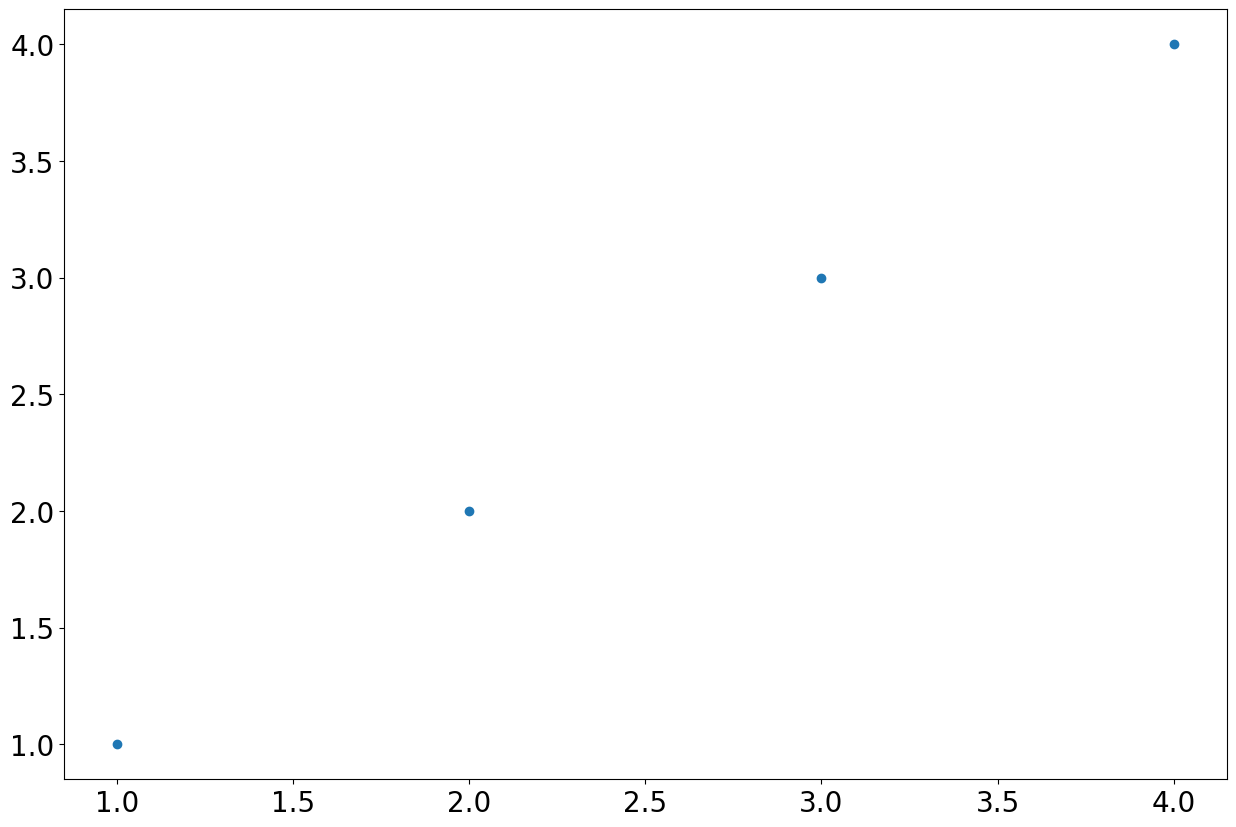

In [3]:
import matplotlib as mpl
#mpl.rcParams['figure.figsize'] = (10, 5) # To increase the size of the plots
#mpl.rcParams['figure.figsize'] = (20, 10) # To increase the size of the plots
mpl.rcParams['figure.figsize'] = (15, 10) # To increase the size of the plots
#mpl.rcParams['figure.figsize'] = (20, 15) # To increase the size of the plots

#======================================================================#
#======================================================================#
# Defining the plot
params = {'axes.labelsize': 20,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20,
          'axes.titlesize': 20}
plt.rcParams.update(params)
axisTickSize = 40
    
# Dummy plot
plt.scatter(x=[1, 2, 3, 4], y=[1, 2, 3, 4])
plt.show()

# I) Load data one patient

## A) Raw data

In [4]:
# Pre-processed data folder
preprocessed_folder = "/home/vindasya/Baobab/Codes/aiidkit/data/preprocessed/"

# Selecting one patient file
patient_ID = "80000189"
patient_file = preprocessed_folder + f"patient_{patient_ID}.csv"

# Loading the file as a pandas dataframe
#df_pat = pd.read_csv(patient_file)

# Getting the infection events
#inf_events_pat = get_all_infection_events(df_pat)

In [5]:
# Process the CSV to get the data of the patient using Alban's and Melanie's code
# IMPORTANT: the output, pat_dict, is a dict having the following keys: 'entity', 'attribute', 'value', 'time', 'days_since_tpx', 'infection_events', 'patient_csv_path'
# IMPORTANT: pat_dict[key] is a list containing the values of the different rows of the patients CSV files.
# IMPORTANT: All static features (age of donnor, warm ischemia time, etc.) have the 'days_since_tpx' 0, which is the time when the transplant 
# IMPORTANT: occured. Therefore, all measurements that happened before the transplant will have a negative 'days_since_tpx'.
# IMPORTANT: The 'days_since_tpx' variable is in days.
pat_dict = build_patient_sample(patient_file)
print(f"\n ===> Keys of pat_dict: {list(pat_dict.keys())}\n")


 ===> Keys of pat_dict: ['entity', 'attribute', 'value', 'time', 'days_since_tpx', 'infection_events', 'patient_csv_path']



In [6]:
# Inspecting some data
# EAV values
tmp_ID = 0
for tmp_key in ['entity', 'attribute', 'value', 'time', 'days_since_tpx']:
    print(f"\n ===> {tmp_key}: {pat_dict[tmp_key][tmp_ID]}")
# Infection events
for inf_event_ID in range(len(pat_dict['infection_events']['infection_time'])):
    inf_event_time_since_tpx = pat_dict['infection_events']['infection_time'][inf_event_ID]
    inf_event_type = pat_dict['infection_events']['infection_type'][inf_event_ID]
    print(f"\n\t===> Infection event {inf_event_time_since_tpx} days after transplantation: {inf_event_type}")


 ===> entity: Receiver baseline lab results

 ===> attribute: HDL chol. level [mmol/L]

 ===> value: 1.27

 ===> time: 2006-03-13

 ===> days_since_tpx: -784

	===> Infection event 310 days after transplantation: Bacterial Infection


## B) Hugging face dataset creation with cutoffs days and different forecast horizons

In [7]:
# Loading a dataset
huggingface_dir_path = "/home/vindasya/Baobab/Codes/aiidkit/data/hf_data/"
metadata_dir_path = "/home/vindasya/Baobab/Codes/aiidkit/data/hf_metadata/"
prediction_horizon = 30
cutoff_days_train = [30, 90]
cutoff_days_valid = [30, 90]
pats_dataset, bin_intervals, vocabs = load_hf_data_and_metadata(
                                                                    data_dir=huggingface_dir_path,
                                                                    metadata_dir=metadata_dir_path,
                                                                    prediction_horizon=prediction_horizon,
                                                                    cutoff_days_train=cutoff_days_train,
                                                                    cutoff_days_valid=cutoff_days_valid,
                                                                )

## C) Heterogeneous graph creation WITH Networkx

In [8]:
def get_patient_data_dicts(patient_ID, patients_dataset, data_split='Train'):
    """
        Get the data dicts of a patient. Two data dicts
        are return, one regrouping all the information
        of the patient in an EAV format (with supplementary
        keys such as days_since_tpx or infection_label_binary_any).
        The second one regroups the main features per date (no
        label information).

        Parameters:
        -----------
        patient_ID: int
            Patient ID int the Hugging Face dataset.
        patients_dataset: datasets.dataset_dict.DatasetDict
            Dataset containing all the patients in an EAV
            format.
        data_split: str
            Split from which we are going to extract the patient
            (usually 'train', 'validation', and 'test')

        Returns:
        --------
        pat_data_dict: dict
            Dictionary regrouping the patient information in an
            EAV format, having the following keys: 
                - 'entity',
                - 'attribute',
                - 'value',
                - 'time',
                - 'days_since_tpx',
                - 'infection_events',
                - 'patient_csv_path',
                - 'value_binned',
                - 'entity_id',
                - 'attribute_id',
                - 'value_id',
                - 'infection_label_binary_any',
                - 'infection_label_binary_bacterial',
                - 'infection_label_binary_viral',
                - 'infection_label_binary_fungal',
                - 'infection_label_categorical',
                - 'infection_label_one_hot',
                - 'cutoff',
                - 'horizon',
                - 'sequence_id'
        pat_data_dict_regrouped: dict
            Dictionary regrouping the main features of the patient
            per date. The keys are the different dates of measurments.
    """
    # Getting patient data
    pat_data_dict = {}
    for tmp_key in list(patients_dataset[data_split.lower()].features.keys()):
        pat_data_dict[tmp_key] = patients_dataset[data_split.lower()][tmp_key][patient_ID]

    # Regrouping patient data by date
    pat_data_dict_regrouped = {}
    for i in range(pat_data_dict['entity'].shape[0]):
        time = pat_data_dict['time'][i]
        if (time.lower() != 'nan'):
            if (pat_data_dict['time'][i] not in pat_data_dict_regrouped):
                pat_data_dict_regrouped[time] = []
            node = {
                        "entity": pat_data_dict['entity'][i],
                        "attribute": pat_data_dict['attribute'][i],
                        "days_since_tpx": pat_data_dict['days_since_tpx'][i],
                        "value": pat_data_dict['value'][i],
                        "time": pat_data_dict['time'][i]
                   }
            pat_data_dict_regrouped[time].append(node)

    return pat_data_dict, pat_data_dict_regrouped

# Test
tmp_pat_ID = 0
pat_data_dict, pat_data_dict_regrouped = get_patient_data_dicts(
                                                                    patient_ID=tmp_pat_ID,
                                                                    patients_dataset=pats_dataset,
                                                                    data_split='Train'
                                                                )


In [9]:
def date_difference_in_days(date_str1, date_str2):
    """
    Computes the difference in days between two date strings (YYYY-MM-DD).

    Parameters:
    -----------
        date_str1: str
            The first date string.
        date_str2: str
            The second date string.

    Returns:
    -----------
        time_diff: int
            The difference in days.
    """
    # Define the expected format
    date_format = "%Y-%m-%d"

    # Convert the strings to datetime objects
    date1 = datetime.strptime(date_str1, date_format)
    date2 = datetime.strptime(date_str2, date_format)

    # Compute the difference (a timedelta object)
    time_difference = date2 - date1

    # Extract the total number of days from the timedelta object
    time_diff = time_difference.days 
    
    return time_diff

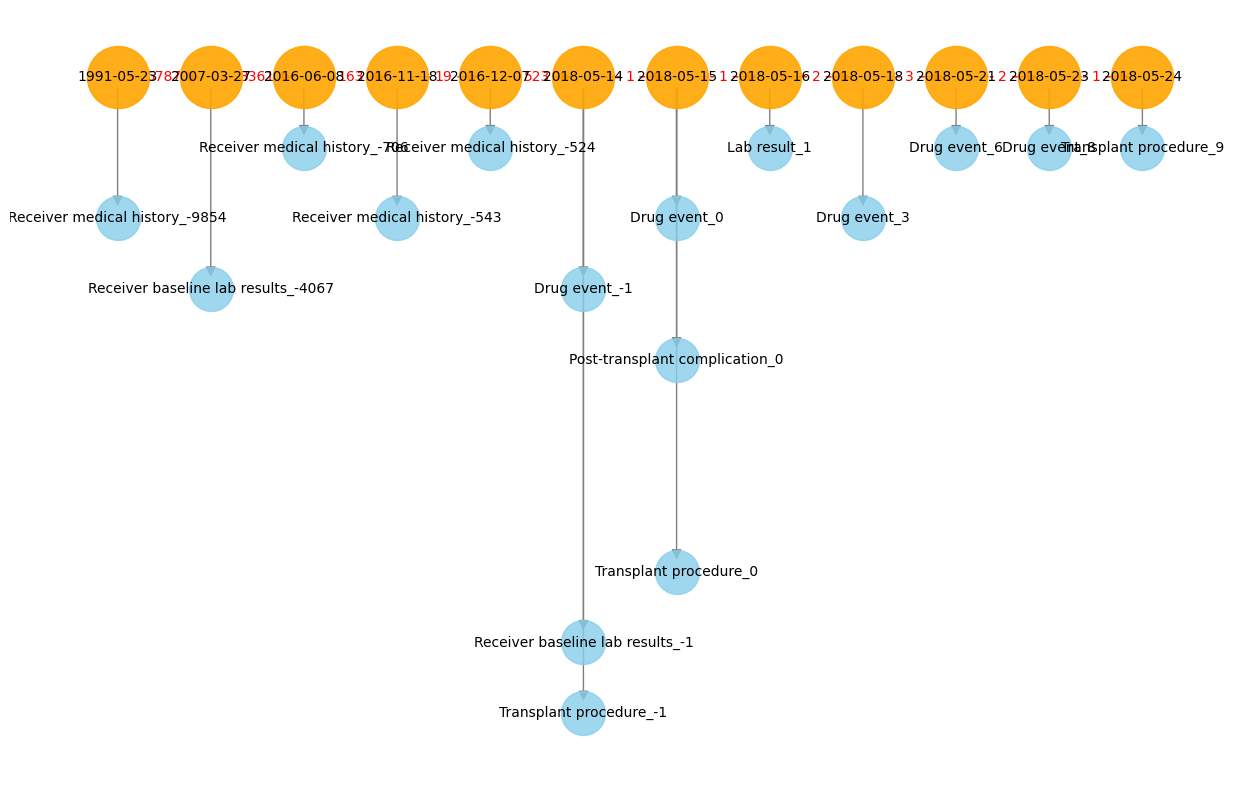

In [10]:
# Create directed graph
G = nx.DiGraph()

# Define central nodes (sequence)
central_nodes = list(pat_data_dict_regrouped.keys())
for c in central_nodes:
    G.add_node(c, ntype="central")

# Add sequence edges between central nodes with attributes
for i in range(len(central_nodes) - 1):
    time_diff_days = date_difference_in_days(central_nodes[i], central_nodes[i + 1])
    G.add_edge(central_nodes[i], central_nodes[i + 1], etype="sequence", label=str(time_diff_days))

# Add children
children = {}
for central_node in central_nodes:
    if central_node not in children:
        children[central_node] = []
    for child in pat_data_dict_regrouped[central_node]:
        children[central_node].append(child['entity'] + f"_{child['days_since_tpx']}")

for parent, kids in children.items():
    for k in kids:
        G.add_node(k, ntype="child")
        # Child edges get a different type
        G.add_edge(parent, k, etype="child_link")

# Layout
pos = {}
for i, c in enumerate(central_nodes):
    pos[c] = (i, 0)
    for j, k in enumerate(children.get(c, [])):
        pos[k] = (i, -(j+1))

# Separate by node type
central_nodes_list = [n for n, d in G.nodes(data=True) if d["ntype"] == "central"]
child_nodes_list   = [n for n, d in G.nodes(data=True) if d["ntype"] == "child"]

# Separate edges by type
sequence_edges = [(u, v) for u, v, d in G.edges(data=True) if d["etype"] == "sequence"]
child_edges    = [(u, v) for u, v, d in G.edges(data=True) if d["etype"] == "child_link"]

# Draw nodes
plt.figure(figsize=(16, 10))
nx.draw_networkx_nodes(G, pos, nodelist=central_nodes_list,
                       node_color="orange", node_size=2000, alpha=0.9)
nx.draw_networkx_nodes(G, pos, nodelist=child_nodes_list,
                       node_color="skyblue", node_size=1000, alpha=0.8)

# Draw edges differently
nx.draw_networkx_edges(G, pos, edgelist=sequence_edges,
                       edge_color="red", style="dashed", arrows=True, arrowstyle="-|>", arrowsize=15)
nx.draw_networkx_edges(G, pos, edgelist=child_edges,
                       edge_color="gray", arrows=True, arrowstyle="-|>", arrowsize=15)

# Labels
nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")

# Draw edge labels for central sequence
edge_labels = {(u, v): d["label"] for u, v, d in G.edges(data=True) if "label" in d}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

plt.axis("off")
plt.show()


# II) Nodes and edges creations for Pytorch Geometric

In practice, in Pytorch Geometric, for each node, we need features. We are going to work with heterogeneous graphs:
- Two type of nodes:
    - Central nodes: indicating the time at which the measurement was done.
    - Child nodes: indicating the different features measured at that day. Here, we represent each child node as a tuple, identified by its entity, attribute, value, and time in days post transplant. For each entity–attribute pair (both categorical and continuous), we construct a dedicated embedding. All entity–attribute pairs share a common embedding layer. To incorporate temporal information, we add a positional embedding that encodes time. For numerical attributes, the pre-processed value is concatenated with the embedding. For categorical attributes, we create a separate embedding layer for each entity–attribute possible values, multiply the resulting embedding by a learnable weight tensor, and add the resulting embedding to the previously obtained representation.
- Two types edges:
    - Edges between central nodes: having as weight the time difference in days between the two measurements.
    - Edges between central nodes and child nodes: no weight.

**IMPORTANT**: To treat the case where new values appear for categorical values, we add an "unknown value" token to each entity-attribute possible values per, to map any new value seen to this token.


In [11]:
# Getting all the possible values for each pair Entity-Attribute in the DS
# USE ONLY TRAIN dataset
possible_values_all_patients = {}
for data_split in ['train']:
#for data_split in tqdm(pats_dataset):
    entity = pats_dataset[data_split]['entity']
    attribute = pats_dataset[data_split]['attribute']
    value = pats_dataset[data_split]['value']
    times = pats_dataset[data_split]['time']
    for pat_ID in tqdm(range(entity.shape[0])):
        n_vals = entity[pat_ID].shape[0]
        for i in range(n_vals):
        #for i in tqdm(range(n_vals)):
            # Get EAV
            ent = entity[pat_ID][i]
            attr = attribute[pat_ID][i]
            val = value[pat_ID][i]
            time = times[pat_ID][i]
            # Add to dict of entity-attribute values
            if ((ent, attr) not in possible_values_all_patients):
                possible_values_all_patients[(ent, attr)] = set()
            possible_values_all_patients[(ent, attr)].add(val)


  0%|          | 0/3740 [00:00<?, ?it/s]

In [12]:
# Function indicating if a str is a float encoded as a string or a real string
def is_float_string(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [13]:
# Separate numerical variables from continuous ones
categorical_ent_attr_pairs = {}
continuous_ent_attr_pairs = {}
for ent, attr in possible_values_all_patients:
    # Test if continuous: if all possible values are floats
    are_all_floats = True
    for val in possible_values_all_patients[(ent, attr)]:
        # Test if float
        is_float = is_float_string(val)
        if (not is_float):
            are_all_floats = False
            break
    # Separating
    if (are_all_floats):
        continuous_ent_attr_pairs[(ent, attr)] = possible_values_all_patients[(ent, attr)]
    else:
        categorical_ent_attr_pairs[(ent, attr)] = possible_values_all_patients[(ent, attr)]
        
# Number of continuous and categorical entity-attr pairs
print(f"\n===> Number of entity-attr pairs with continuous values: {len(continuous_ent_attr_pairs)}")
print(f"\n===> Number of entity-attr pairs with categorical values: {len(categorical_ent_attr_pairs)}")


===> Number of entity-attr pairs with continuous values: 39

===> Number of entity-attr pairs with categorical values: 120


In [14]:
# Number of possible values per categorical variables
for ent_attr_pair in categorical_ent_attr_pairs:
    print(f"\n===>For entity-attribute {ent_attr_pair} there are {len(categorical_ent_attr_pairs[ent_attr_pair])} possible values\n")
    #if (len(categorical_ent_attr_pairs[ent_attr_pair]) > 30):
        #print(f"\t=======>{ent_attr_pair}: {categorical_ent_attr_pairs[ent_attr_pair]}\n\n")


===>For entity-attribute ('Receiver medical history', 'Etiology histology') there are 3 possible values


===>For entity-attribute ('Receiver medical history', 'MEK diagnosis') there are 11 possible values


===>For entity-attribute ('Receiver medical history', 'Any other diagnosis') there are 11 possible values


===>For entity-attribute ('Receiver medical history', 'Etiology') there are 13 possible values


===>For entity-attribute ('Receiver medical history', 'Initial dialysis type') there are 2 possible values


===>For entity-attribute ('Drug event', 'Drug start') there are 87 possible values


===>For entity-attribute ('Receiver baseline lab results', 'Glucose test result') there are 4 possible values


===>For entity-attribute ('Receiver baseline lab results', 'HBA1C test result') there are 3 possible values


===>For entity-attribute ('Transplant procedure', 'Hospitalization') there are 2 possible values


===>For entity-attribute ('Post-transplant complication', 'DGF') there 

In [15]:
# Getting the number of categories for each categorical pair Entity-Attribute
n_categorical_per_ent_attr_pair = {}
n_var_one_category = 0
for ent, attr in categorical_ent_attr_pairs:
    n_categorical_per_ent_attr_pair[(ent, attr)] = len(categorical_ent_attr_pairs[(ent, attr)])
    if (n_categorical_per_ent_attr_pair[(ent, attr)] == 1):
        print(f"Entity-Attribute pair ({ent}, {attr}) has the {n_categorical_per_ent_attr_pair[(ent, attr)]} possible values: {categorical_ent_attr_pairs[(ent, attr)]}\n")
        n_var_one_category += 1
print(f"\n\n=========>A total of {n_var_one_category} samples only have one category")

Entity-Attribute pair (Post-transplant complication, DGF) has the 1 possible values: {'No'}

Entity-Attribute pair (Parasitic Infection, Clinically significant) has the 1 possible values: {'False'}

Entity-Attribute pair (Parasitic Infection, Donor related infection) has the 1 possible values: {'NO'}

Entity-Attribute pair (Parasitic Infection, Pathogens Parasitic primary infection) has the 1 possible values: {'0: Primary infection'}



=========>A total of 4 samples only have one category


# III) Create Pytorch Geometric Dataset

### A) Create a graph for each patient

In [16]:
# Create IDs for all the entity-attribute pairs
possible_ent_attr_pairs = list(possible_values_all_patients)
ids_ent_attr_pairs = {possible_ent_attr_pairs[i]: i for i in range(len(possible_ent_attr_pairs))}
inv_ids_ent_attr_pairs = {ids_ent_attr_pairs[ent_attr_pair]: ent_attr_pair for ent_attr_pair in ids_ent_attr_pairs}

# Create embedding layer
emb_dim_ent_attr = 8
ent_attr_pair_emb_layer = torch.nn.Embedding(len(inv_ids_ent_attr_pairs), emb_dim_ent_attr)  # one embedding per entity-attr pair

In [17]:
# Creating embedding layers for categorical values for entity-attribute pairs
categorical_vals_vocabs = {}
categorical_vals_emb_layers = {}
emb_dim_ent_attr_vals = 8
for ent, attr in categorical_ent_attr_pairs:
    # Remove Unknown if exists
    categorical_ent_attr_pairs[(ent, attr)].discard('Unknown')
    categorical_ent_attr_pairs[(ent, attr)].discard('unknown')
    # Add Unknown token <UNK>
    categorical_ent_attr_pairs[(ent, attr)].add('<UNK>')
    categorical_vals_vocabs[(ent, attr)] = {value: index for index, value in enumerate(categorical_ent_attr_pairs[(ent, attr)])}
    categorical_vals_emb_layers[(ent, attr)] = torch.nn.Embedding(len(categorical_vals_vocabs[(ent, attr)]), emb_dim_ent_attr_vals)
    

In [18]:
def positional_encoding(pos, d):
    """
        Generates sinusoidal positional encoding for a given position/time
        
        Parameters:
        -----------
        pos: int or torch.tensor of shape [num_nodes]
            Time (int) used to generate the positional embedding        
        d: intr
            Embedding dimension

        Returns:
        --------
        pe: torch.tensor
            Embedding tensor
    """
    if (type(pos) == torch.Tensor):
        pe = torch.zeros(len(pos), d)
    else:
        pos = torch.tensor(pos)
        pe = torch.zeros(1, d)
    for k in range(d):
        if k % 2 == 0: # Even k = 2*i
            div_term = 10000 ** (k / d)
            pe[:, k] = torch.sin(pos / div_term)
        else: # Odd k = 2*i+1
            div_term = 10000 ** ((k-1) / d)
            pe[:, k] = torch.cos(pos / div_term)
    return pe



In [19]:
def build_hetero_graph_with_embeddings(
                                        pat_data_dict_regrouped,
                                        ids_ent_attr_pairs,
                                        continuous_ent_attr_pairs,
                                        categorical_ent_attr_pairs,
                                        categorical_vals_emb_layers,
                                        ent_attr_pair_emb_layer,
                                        #constant_edges_without_attr=0.
                                        constant_edges_without_attr=1.
                                      ):
    """
        Returns a Pytorch Geometric heterogeneous data representing
        the patient trajectory.

        Parameters:
        -----------
        pat_data_dict_regrouped: dict
            Dictionary regrouping the patient's features by date 
            (the keys are the times of measurments of patient
            information).
        ids_ent_attr_pairs: dict
            Dictionary giving unique IDs to pairs (entity, attribute),
            necessary to use embeddings. The keys are (entity, attribute)
            pairs and the values are the IDs.
        continuous_ent_attr_pairs: dict
            Subset of ids_ent_attr_pairs getting only the (entity, attribute)
            pairs having continuous (float) values.
        categorical_ent_attr_pairs: dict
            Subset of ids_ent_attr_pairs getting only the (entity, attribute)
            pairs having categorical values.
        categorical_vals_emb_layers: dict
            Dictionary of nn.Embedding layers where the keys are 
            list of the form (entity, attribute) and the values
            are the nn.Embedding layers.
        ent_attr_pair_emb_layer: nn.Embedding
            Embedding layer for (entity, attribute) pairs.
        constant_edges_without_attr: float
            Value to use in attribute in edges that does not have attributes.
            Using a value of 0 does not necessarily means that there is 
            no edge between nodes.

        Returns:
        --------
        pat_data_graph: HeteroData
            Heterogeneous graph representing the patient's trajectory.
    """
    # Creating graph Pytorch Geometric structure for patient
    pat_data_graph = HeteroData()
    
    # Central nodes (time feature only, float)
    central_nodes = torch.from_numpy(np.unique([int(pat_data_dict_regrouped[key][i]['days_since_tpx']) for key in pat_data_dict_regrouped for i in range(len(pat_data_dict_regrouped[key]))]).reshape(-1, 1))
    pat_data_graph["central"].x = central_nodes
    
    # Child nodes IDs and values
    children_ent_attr_continuous_ids = []
    children_ent_attr_continuous_values = []
    children_ent_attr_continuous_times = []
    children_ent_attr_continuous_days_since_tpx = []
    children_ent_attr_categorical_ids = []
    children_ent_attr_categorical_values = []
    children_ent_attr_categorical_times = []
    children_ent_attr_categorical_days_since_tpx = []
    for day in pat_data_dict_regrouped:
        n_childs = len(pat_data_dict_regrouped[day])
        for child_local_ID in range(n_childs):
            # Getting the child entity-attribute ID
            child = pat_data_dict_regrouped[day][child_local_ID]
            ent_attr_pair = (child['entity'], child['attribute'])
            id_ent_attr_pair = ids_ent_attr_pairs[ent_attr_pair]
    
            # Getting the value
            if (ent_attr_pair in continuous_ent_attr_pairs):
                children_ent_attr_continuous_ids.append(id_ent_attr_pair)
                children_ent_attr_continuous_values.append(float(child['value']))
                children_ent_attr_continuous_times.append(child['time'])
                children_ent_attr_continuous_days_since_tpx.append(child['days_since_tpx'])
            elif (ent_attr_pair in categorical_ent_attr_pairs):
                children_ent_attr_categorical_ids.append(id_ent_attr_pair)
                children_ent_attr_categorical_values.append([ent_attr_pair, child['value']])
                children_ent_attr_categorical_times.append(child['time'])
                children_ent_attr_categorical_days_since_tpx.append(child['days_since_tpx'])
    
                
    children_ent_attr_continuous_ids = torch.tensor(children_ent_attr_continuous_ids)
    children_ent_attr_continuous_values = torch.tensor(children_ent_attr_continuous_values)
    children_ent_attr_continuous_days_since_tpx = torch.tensor(children_ent_attr_continuous_days_since_tpx)
    children_ent_attr_categorical_ids = torch.tensor(children_ent_attr_categorical_ids)
    children_ent_attr_categorical_emb = torch.stack([categorical_vals_emb_layers[c[0]](torch.tensor(categorical_vals_vocabs[c[0]].get(c[1], categorical_vals_vocabs[c[0]]["<UNK>"]))) for c in children_ent_attr_categorical_values])
    children_ent_attr_categorical_days_since_tpx = torch.tensor(children_ent_attr_categorical_days_since_tpx)
    
    # Child node features
    # Continuous
    ent_attr_pair_cont_emb = ent_attr_pair_emb_layer(children_ent_attr_continuous_ids)
    ent_attr_pair_cont_emb = torch.cat([ent_attr_pair_cont_emb, children_ent_attr_continuous_values.unsqueeze(-1)], dim=-1)
    pos_enc_cont_emb = positional_encoding(pos=children_ent_attr_continuous_days_since_tpx, d=ent_attr_pair_cont_emb.shape[1])
    child_cont_features = ent_attr_pair_cont_emb + pos_enc_cont_emb
    pat_data_graph['child_cont'].x = child_cont_features
    
    # Categorical
    ent_attr_pair_categ_emb = ent_attr_pair_emb_layer(children_ent_attr_categorical_ids)
    ent_attr_pair_categ_emb = ent_attr_pair_categ_emb + children_ent_attr_categorical_emb
    pos_enc_categ_emb = positional_encoding(pos=children_ent_attr_categorical_days_since_tpx, d=ent_attr_pair_categ_emb.shape[1])
    child_categ_features = ent_attr_pair_categ_emb + pos_enc_categ_emb
    pat_data_graph['child_categ'].x = child_categ_features
    
    # Create the edges
    # Between central nodes
    central_nodes_edge_idx = torch.tensor([ [i for i in range(len(central_nodes)-1)], [j for j in range(1, len(central_nodes))]])
    central_nodes_times = [key for key in pat_data_dict_regrouped]
    edges_central_nodes_edge_attr = torch.tensor([date_difference_in_days(central_nodes_times[i], central_nodes_times[i+1]) for i in range(len(central_nodes_times)-1)]).unsqueeze(1)
    pat_data_graph["central", "sequence", "central"].edge_index = central_nodes_edge_idx
    pat_data_graph["central", "sequence", "central"].edge_attr = edges_central_nodes_edge_attr
    # Between central nodes and child nodes
    central_to_child_cont_edge_idx = [[], []]
    central_to_child_categ_edge_idx = [[], []]
    for central_node_i in range(central_nodes.shape[0]):
        time_central_node = central_nodes_times[central_node_i]
        # Continuous nodes
        for child_cont_j in range(len(children_ent_attr_continuous_times)):
            time_child_cont = children_ent_attr_continuous_times[child_cont_j]
            if (time_central_node == time_child_cont):
                central_to_child_cont_edge_idx[0].append(central_node_i)
                central_to_child_cont_edge_idx[1].append(child_cont_j)
        # Categorical nodes
        for child_categ_j in range(len(children_ent_attr_categorical_times)):
            time_child_categ = children_ent_attr_categorical_times[child_categ_j]
            if (time_central_node == time_child_categ):
                central_to_child_categ_edge_idx[0].append(central_node_i)
                central_to_child_categ_edge_idx[1].append(child_categ_j)
    central_to_child_cont_edge_idx = torch.tensor(central_to_child_cont_edge_idx)
    central_to_child_categ_edge_idx = torch.tensor(central_to_child_categ_edge_idx)
    pat_data_graph["central", "has_child", "child_cont"].edge_index = central_to_child_cont_edge_idx
    pat_data_graph["central", "has_child", "child_cont"].edge_attr = constant_edges_without_attr
    pat_data_graph["central", "has_child", "child_categ"].edge_index = central_to_child_categ_edge_idx
    pat_data_graph["central", "has_child", "child_categ"].edge_attr = constant_edges_without_attr

    return pat_data_graph
    
# Test
#CST_DUMMY_EDGE = 0
CST_DUMMY_EDGE = 1
pat_data_graph = build_hetero_graph_with_embeddings(
                                                        pat_data_dict_regrouped=pat_data_dict_regrouped,
                                                        ids_ent_attr_pairs=ids_ent_attr_pairs,
                                                        continuous_ent_attr_pairs=continuous_ent_attr_pairs,
                                                        categorical_ent_attr_pairs=categorical_ent_attr_pairs,
                                                        categorical_vals_emb_layers=categorical_vals_emb_layers,
                                                        ent_attr_pair_emb_layer=ent_attr_pair_emb_layer,
                                                        constant_edges_without_attr=CST_DUMMY_EDGE
                                                      )

In [20]:
# Plot graph
def hetero_to_networkx(data: HeteroData):
    G = nx.DiGraph()

    # Add central nodes
    for i, feat in enumerate(data["central"].x):
        G.add_node(f"C{i}", type="central", feature=feat.item())

    # Add child nodes
    try:
        for i, feat in enumerate(data["child_cont"].x):
            G.add_node(f"H{i}", type="child_cont")
        for i, feat in enumerate(data["child_categ"].x):
            G.add_node(f"H{i}", type="child_categ")
    except:
        for i, feat in enumerate(data["child_cont"].ent_attr_ids):
            G.add_node(f"H{i}", type="child_cont")
        for i, feat in enumerate(data["child_categ"].ent_attr_ids):
            G.add_node(f"H{i}", type="child_categ")

    # Add edges (central -> central)
    src, dst = data["central", "sequence", "central"].edge_index
    for s, d in zip(src.tolist(), dst.tolist()):
        G.add_edge(f"C{s}", f"C{d}", type="sequence")

    # Add edges (central -> child)
    src, dst = data["central", "has_child", "child_cont"].edge_index
    for s, d in zip(src.tolist(), dst.tolist()):
        G.add_edge(f"C{s}", f"H{d}", type="child_cont")
    src, dst = data["central", "has_child", "child_categ"].edge_index
    for s, d in zip(src.tolist(), dst.tolist()):
        G.add_edge(f"C{s}", f"H{d}", type="child_categ")

    return G

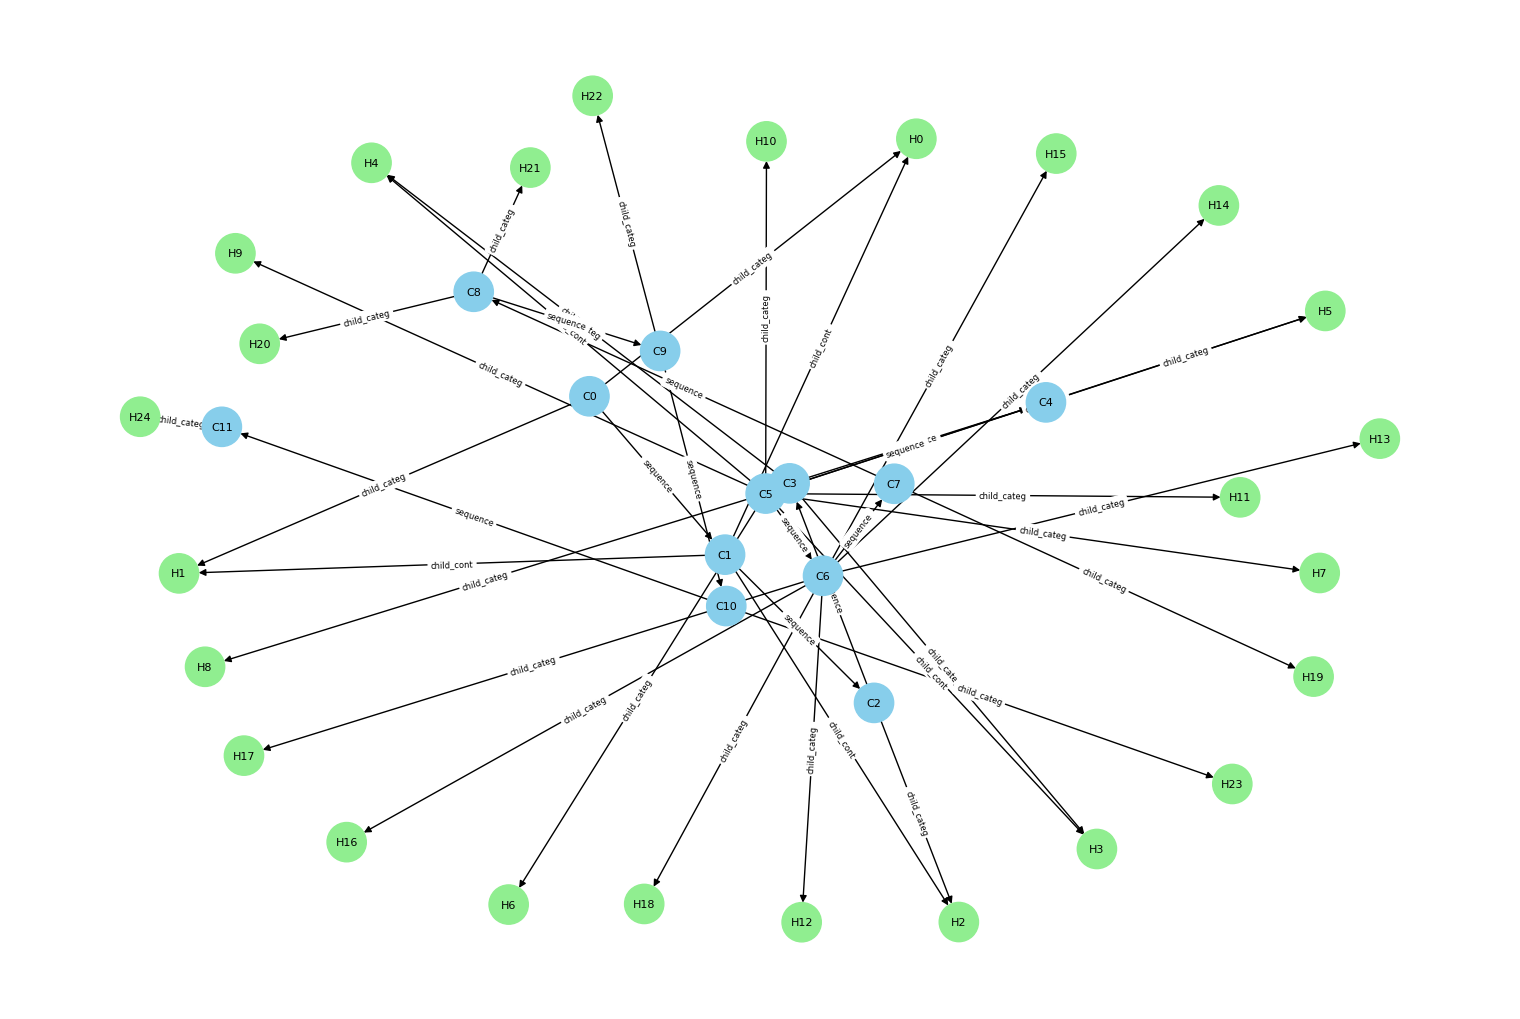

In [21]:
# Plot previous graph
G = hetero_to_networkx(pat_data_graph)

# Draw with colors by node type
color_map = ["skyblue" if G.nodes[n]["type"] == "central" else "lightgreen" for n in G.nodes]
pos = nx.spring_layout(G, seed=42)

nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=800, font_size=8)
edge_labels = nx.get_edge_attributes(G, "type")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

plt.show()

In [22]:
def build_hetero_graph_without_embeddings(
                                        pat_data_dict_regrouped,
                                        ids_ent_attr_pairs,
                                        continuous_ent_attr_pairs,
                                        categorical_ent_attr_pairs,
                                        #constant_edges_without_attr=0.
                                        constant_edges_without_attr=1.
                                      ):
    """
        Returns a Pytorch Geometric heterogeneous data representing
        the patient trajectory.

        Parameters:
        -----------
        pat_data_dict_regrouped: dict
            Dictionary regrouping the patient's features by date 
            (the keys are the times of measurments of patient
            information).
        ids_ent_attr_pairs: dict
            Dictionary giving unique IDs to pairs (entity, attribute),
            necessary to use embeddings. The keys are (entity, attribute)
            pairs and the values are the IDs.
        continuous_ent_attr_pairs: dict
            Subset of ids_ent_attr_pairs getting only the (entity, attribute)
            pairs having continuous (float) values.
        categorical_ent_attr_pairs: dict
            Subset of ids_ent_attr_pairs getting only the (entity, attribute)
            pairs having categorical values.
        constant_edges_without_attr: float
            Value to use in attribute in edges that does not have attributes.
            Using a value of 0 does not necessarily means that there is 
            no edge between nodes.

        Returns:
        --------
        pat_data_graph: HeteroData
            Heterogeneous graph representing the patient's trajectory.
    """
    # Creating graph Pytorch Geometric structure for patient
    pat_data_graph = HeteroData()
    
    # Central nodes (time feature only, float)
    central_nodes = torch.from_numpy(np.unique([int(pat_data_dict_regrouped[key][i]['days_since_tpx']) for key in pat_data_dict_regrouped for i in range(len(pat_data_dict_regrouped[key]))]).reshape(-1, 1))
    pat_data_graph["central"].x = central_nodes.float()
    # TO BE ABLE TO USE BATCHING, WE ADD DUMMY FEATURES SO THAT ALL THE NODE TYPES HAVE THE SAME ATTRIBUTES
    pat_data_graph['central'].ent_attr_ids = torch.zeros(pat_data_graph["central"].x.shape)
    pat_data_graph['central'].vals = torch.zeros(pat_data_graph["central"].x.shape)
    pat_data_graph['central'].vocab_ids = torch.zeros(pat_data_graph["central"].x.shape)
    pat_data_graph['central'].days_since_tpx = torch.zeros(pat_data_graph["central"].x.shape)
    
    
    # Child nodes IDs and values
    children_ent_attr_continuous_ids = []
    children_ent_attr_continuous_values = []
    children_ent_attr_continuous_times = []
    children_ent_attr_continuous_days_since_tpx = []
    children_ent_attr_categorical_ids = []
    children_ent_attr_categorical_values = []
    children_ent_attr_categorical_times = []
    children_ent_attr_categorical_days_since_tpx = []
    for day in pat_data_dict_regrouped:
        n_childs = len(pat_data_dict_regrouped[day])
        for child_local_ID in range(n_childs):
            # Getting the child entity-attribute ID
            child = pat_data_dict_regrouped[day][child_local_ID]
            ent_attr_pair = (child['entity'], child['attribute'])
            id_ent_attr_pair = ids_ent_attr_pairs[ent_attr_pair]
    
            # Getting the value
            if (ent_attr_pair in continuous_ent_attr_pairs):
                children_ent_attr_continuous_ids.append(id_ent_attr_pair)
                children_ent_attr_continuous_values.append(float(child['value']))
                children_ent_attr_continuous_times.append(child['time'])
                children_ent_attr_continuous_days_since_tpx.append(child['days_since_tpx'])
            elif (ent_attr_pair in categorical_ent_attr_pairs):
                children_ent_attr_categorical_ids.append(id_ent_attr_pair)
                children_ent_attr_categorical_values.append([ent_attr_pair, child['value']])
                children_ent_attr_categorical_times.append(child['time'])
                children_ent_attr_categorical_days_since_tpx.append(child['days_since_tpx'])
    
                
    children_ent_attr_continuous_ids = torch.tensor(children_ent_attr_continuous_ids)
    children_ent_attr_continuous_values = torch.tensor(children_ent_attr_continuous_values)
    children_ent_attr_continuous_days_since_tpx = torch.tensor(children_ent_attr_continuous_days_since_tpx)
    children_ent_attr_categorical_ids = torch.tensor(children_ent_attr_categorical_ids)
    children_ent_attr_categorical_vocab_ids = torch.stack([torch.tensor(categorical_vals_vocabs[c[0]].get(c[1], categorical_vals_vocabs[c[0]]["<UNK>"])) for c in children_ent_attr_categorical_values])
    children_ent_attr_categorical_days_since_tpx = torch.tensor(children_ent_attr_categorical_days_since_tpx)
    
    # Child node features
    # Continuous
    pat_data_graph['child_cont'].ent_attr_ids = children_ent_attr_continuous_ids
    pat_data_graph['child_cont'].vals = children_ent_attr_continuous_values # .values cannot be used as it is already used by Pytorch Geometric
    pat_data_graph['child_cont'].days_since_tpx = children_ent_attr_continuous_days_since_tpx
    # TO BE ABLE TO USE BATCHING, WE ADD DUMMY FEATURES SO THAT ALL THE NODE TYPES HAVE THE SAME ATTRIBUTES
    pat_data_graph['child_cont'].vocab_ids = torch.zeros(pat_data_graph['child_cont'].days_since_tpx.shape)
    pat_data_graph["child_cont"].x = torch.zeros(pat_data_graph['child_cont'].days_since_tpx.shape)
    
    # Categorical
    pat_data_graph['child_categ'].ent_attr_ids = children_ent_attr_categorical_ids
    pat_data_graph['child_categ'].vocab_ids = children_ent_attr_categorical_vocab_ids
    pat_data_graph['child_categ'].days_since_tpx = children_ent_attr_categorical_days_since_tpx
    # TO BE ABLE TO USE BATCHING, WE ADD DUMMY FEATURES SO THAT ALL THE NODE TYPES HAVE THE SAME ATTRIBUTES
    pat_data_graph['child_categ'].vals = torch.zeros(pat_data_graph['child_categ'].days_since_tpx.shape)
    pat_data_graph["child_categ"].x = torch.zeros(pat_data_graph['child_categ'].days_since_tpx.shape)
    
    # Create the edges
    # Between central nodes
    central_nodes_edge_idx = torch.tensor([ [i for i in range(len(central_nodes)-1)], [j for j in range(1, len(central_nodes))]])
    central_nodes_times = [key for key in pat_data_dict_regrouped]
    edges_central_nodes_edge_attr = torch.tensor([date_difference_in_days(central_nodes_times[i], central_nodes_times[i+1]) for i in range(len(central_nodes_times)-1)]).unsqueeze(1)
    pat_data_graph["central", "sequence", "central"].edge_index = central_nodes_edge_idx
    pat_data_graph["central", "sequence", "central"].edge_attr = edges_central_nodes_edge_attr
    # Between central nodes and child nodes
    central_to_child_cont_edge_idx = [[], []]
    central_to_child_categ_edge_idx = [[], []]
    for central_node_i in range(central_nodes.shape[0]):
        time_central_node = central_nodes_times[central_node_i]
        # Continuous nodes
        for child_cont_j in range(len(children_ent_attr_continuous_times)):
            time_child_cont = children_ent_attr_continuous_times[child_cont_j]
            if (time_central_node == time_child_cont):
                central_to_child_cont_edge_idx[0].append(central_node_i)
                central_to_child_cont_edge_idx[1].append(child_cont_j)
        # Categorical nodes
        for child_categ_j in range(len(children_ent_attr_categorical_times)):
            time_child_categ = children_ent_attr_categorical_times[child_categ_j]
            if (time_central_node == time_child_categ):
                central_to_child_categ_edge_idx[0].append(central_node_i)
                central_to_child_categ_edge_idx[1].append(child_categ_j)
    central_to_child_cont_edge_idx = torch.tensor(central_to_child_cont_edge_idx)
    central_to_child_categ_edge_idx = torch.tensor(central_to_child_categ_edge_idx)
    pat_data_graph["central", "has_child", "child_cont"].edge_index = central_to_child_cont_edge_idx
    pat_data_graph["central", "has_child", "child_cont"].edge_attr = constant_edges_without_attr
    pat_data_graph["central", "has_child", "child_categ"].edge_index = central_to_child_categ_edge_idx
    pat_data_graph["central", "has_child", "child_categ"].edge_attr = constant_edges_without_attr

    return pat_data_graph
    
# Test
pat_data_graph_without_embeddings = build_hetero_graph_without_embeddings(
                                                                            pat_data_dict_regrouped=pat_data_dict_regrouped,
                                                                            ids_ent_attr_pairs=ids_ent_attr_pairs,
                                                                            continuous_ent_attr_pairs=continuous_ent_attr_pairs,
                                                                            categorical_ent_attr_pairs=categorical_ent_attr_pairs,
                                                                            constant_edges_without_attr=CST_DUMMY_EDGE
                                                                          )


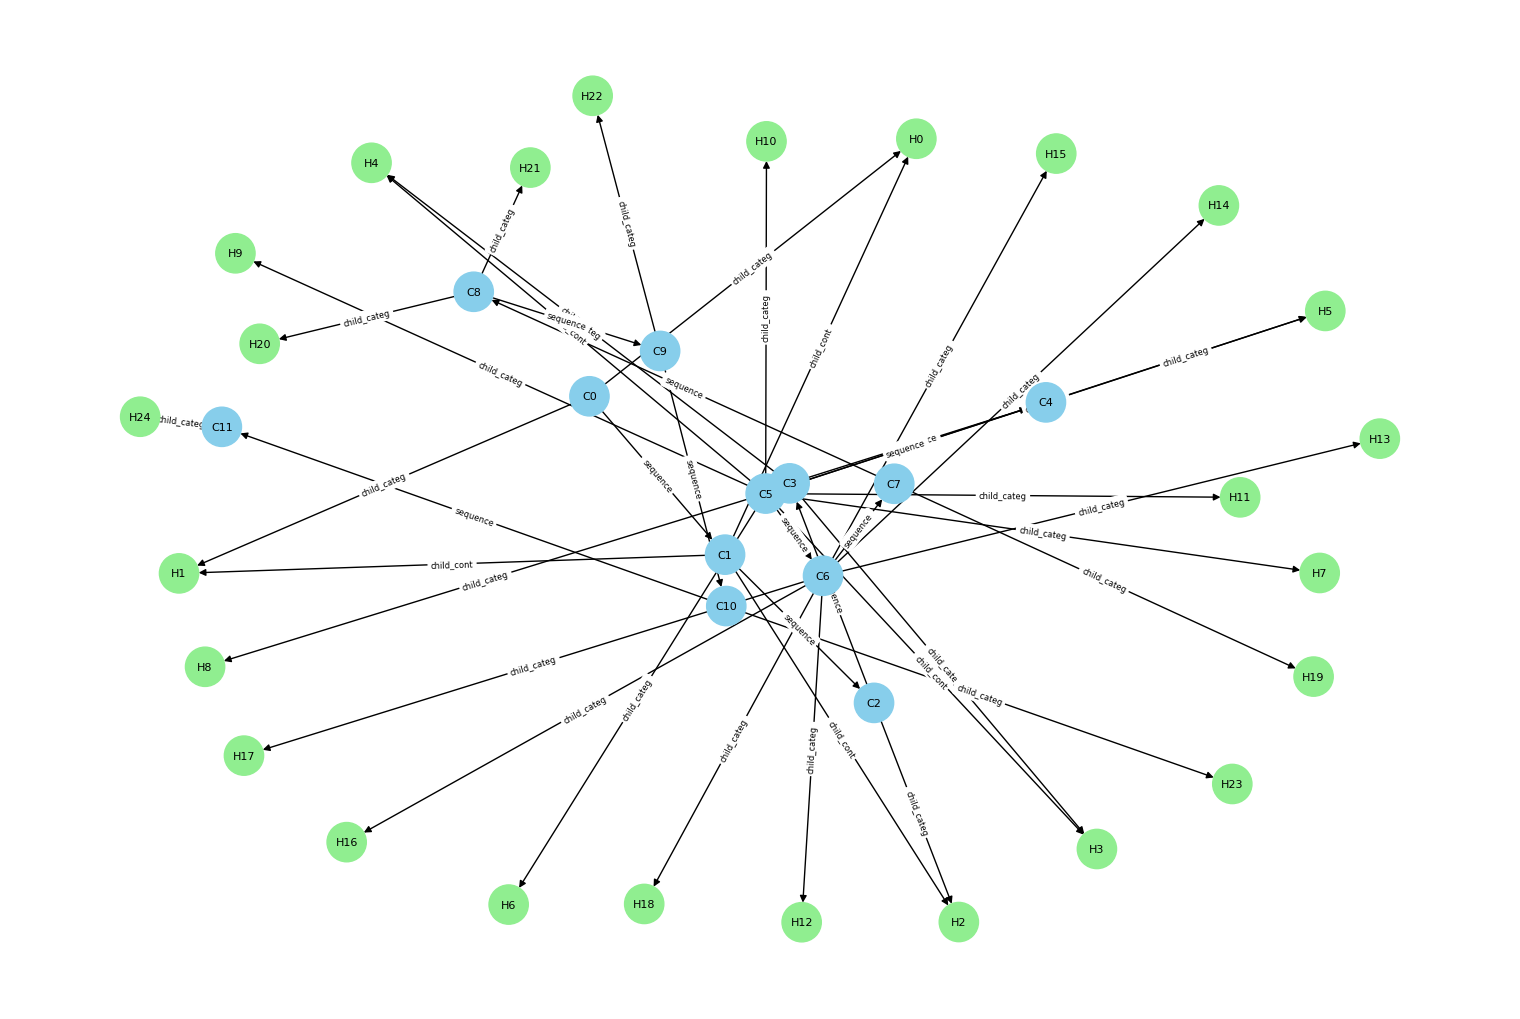

In [23]:
# Plot previous graph
G = hetero_to_networkx(pat_data_graph_without_embeddings)

# Draw with colors by node type
color_map = ["skyblue" if G.nodes[n]["type"] == "central" else "lightgreen" for n in G.nodes]
pos = nx.spring_layout(G, seed=42)

nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=800, font_size=8)
edge_labels = nx.get_edge_attributes(G, "type")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6)

plt.show()

In [24]:
class AiidkitTEAVGraphEmbedder(torch.nn.Module):
    def __init__(
                    self,
                    possible_values_all_patients,
                    categorical_ent_attr_pairs,
                    emb_dim_ent_attr=8,
                    emb_dim_ent_attr_vals=8
                ):
        """
            Model to get the embeddings of a TEAV AIIDKIT data representation, that
            can then be used with GNN models.
        """
        super().__init__()
        # Create IDs for all the entity-attribute pairs
        possible_ent_attr_pairs = list(possible_values_all_patients)
        ids_ent_attr_pairs = {possible_ent_attr_pairs[i]: i for i in range(len(possible_ent_attr_pairs))}
        self.inv_ids_ent_attr_pairs = {ids_ent_attr_pairs[ent_attr_pair]: ent_attr_pair for ent_attr_pair in ids_ent_attr_pairs}
        
        # Create embedding layer
        self.ent_attr_pair_emb_layer = torch.nn.Embedding(len(self.inv_ids_ent_attr_pairs), emb_dim_ent_attr)  # one embedding per entity-attr pair
        
        # Creating embedding layers for categorical values for entity-attribute pairs
        categorical_vals_vocabs = {}
        categorical_vals_emb_layers = {}
        for ent, attr in categorical_ent_attr_pairs:
            # Remove Unknown if exists
            categorical_ent_attr_pairs[(ent, attr)].discard('Unknown')
            categorical_ent_attr_pairs[(ent, attr)].discard('unknown')
            # Add Unknown token <UNK>
            categorical_ent_attr_pairs[(ent, attr)].add('<UNK>')
            categorical_vals_vocabs[(ent, attr)] = {value: index for index, value in enumerate(categorical_ent_attr_pairs[(ent, attr)])}
            tmp_ent = ent.replace(".", "") # Because torch.nn.ModuleDict does not accept . in the keys
            tmp_attr = attr.replace(".", "") # Because torch.nn.ModuleDict does not accept . in the keys
            categorical_vals_emb_layers[f"{tmp_ent}\\SEP\\{tmp_attr}"] = torch.nn.Embedding(len(categorical_vals_vocabs[(ent, attr)]), emb_dim_ent_attr_vals)
        self.categorical_vals_emb_layers = torch.nn.ModuleDict(categorical_vals_emb_layers)


    # OLD VERSION BEFORE 08/10/2025 WHERE WE CONSIDERED THAT THE INPUTS ARE OF THE FORM [batch_size, ...]
    """
    def forward(self, pat_data_graph):
        
        # Child node features
        # Continuous
        if (len(pat_data_graph['child_cont'].vals.shape) == 1): # Not batched input
            pat_data_graph['child_cont'].vals = pat_data_graph['child_cont'].vals.unsqueeze(0)
            pat_data_graph['child_cont'].ent_attr_ids = pat_data_graph['child_cont'].ent_attr_ids.unsqueeze(0)
        ent_attr_pair_cont_emb = self.ent_attr_pair_emb_layer(pat_data_graph['child_cont'].ent_attr_ids)
        ent_attr_pair_cont_emb = torch.cat([ent_attr_pair_cont_emb, pat_data_graph['child_cont'].vals.unsqueeze(-1)], dim=-1)
        pos_enc_cont_emb = positional_encoding(pos=pat_data_graph['child_cont'].days_since_tpx, d=ent_attr_pair_cont_emb.shape[2])
        child_cont_features = ent_attr_pair_cont_emb + pos_enc_cont_emb
        
        # Categorical
        ent_attr_pair_categ_emb = self.ent_attr_pair_emb_layer(pat_data_graph['child_categ'].ent_attr_ids)
        if (len(pat_data_graph['child_categ'].vocab_ids.shape) == 1): # Not batched input
            pat_data_graph['child_categ'].vocab_ids = pat_data_graph['child_categ'].vocab_ids.unsqueeze(0)
            pat_data_graph['child_categ'].ent_attr_ids = pat_data_graph['child_categ'].ent_attr_ids.unsqueeze(0)
        bs, n = pat_data_graph['child_categ'].vocab_ids.shape
        children_ent_attr_categorical_emb = []
        for i in range(bs):
            batch_out = []
            for j in range(n):
                vocab_id = pat_data_graph['child_categ'].vocab_ids[i, j]
                tmp_ent, tmp_attr = self.inv_ids_ent_attr_pairs[int(pat_data_graph['child_categ'].ent_attr_ids[i, j])]
                tmp_ent = tmp_ent.replace(".", "") # Because torch.nn.ModuleDict does not accept . in the keys
                tmp_attr = tmp_attr.replace(".", "") # Because torch.nn.ModuleDict does not accept . in the keys
                emb_layer_name = f"{tmp_ent}\\SEP\\{tmp_attr}"
                batch_out.append(self.categorical_vals_emb_layers[emb_layer_name](vocab_id))
            batch_out = torch.stack(batch_out)
            children_ent_attr_categorical_emb.append(batch_out)
        children_ent_attr_categorical_emb = torch.stack(children_ent_attr_categorical_emb)
        ent_attr_pair_categ_emb = ent_attr_pair_categ_emb + children_ent_attr_categorical_emb
        pos_enc_categ_emb = positional_encoding(pos=pat_data_graph['child_categ'].days_since_tpx, d=ent_attr_pair_categ_emb.shape[2])
        child_categ_features = ent_attr_pair_categ_emb + pos_enc_categ_emb

        return child_cont_features, child_categ_features
    """

    # NEW VERSION BASED ON THE BATCHED FORM USED BY TORCH GEOEMTRIC (ALL NODES ARE CONCATENATED)
    def forward(self, pat_data_graph):
        
        # Child node features
        # Continuous
        ent_attr_pair_cont_emb = self.ent_attr_pair_emb_layer(pat_data_graph['child_cont'].ent_attr_ids)
        ent_attr_pair_cont_emb = torch.cat([ent_attr_pair_cont_emb, pat_data_graph['child_cont'].vals.unsqueeze(-1)], dim=-1)
        pos_enc_cont_emb = positional_encoding(pos=pat_data_graph['child_cont'].days_since_tpx, d=ent_attr_pair_cont_emb.shape[1]).to(ent_attr_pair_cont_emb.device)
        child_cont_features = ent_attr_pair_cont_emb + pos_enc_cont_emb
        
        # Categorical
        ent_attr_pair_categ_emb = self.ent_attr_pair_emb_layer(pat_data_graph['child_categ'].ent_attr_ids)
        n = pat_data_graph['child_categ'].vocab_ids.shape[0]
        children_ent_attr_categorical_emb = []
        for j in range(n):
            vocab_id = pat_data_graph['child_categ'].vocab_ids[j]
            tmp_ent, tmp_attr = self.inv_ids_ent_attr_pairs[int(pat_data_graph['child_categ'].ent_attr_ids[j])]
            tmp_ent = tmp_ent.replace(".", "") # Because torch.nn.ModuleDict does not accept . in the keys
            tmp_attr = tmp_attr.replace(".", "") # Because torch.nn.ModuleDict does not accept . in the keys
            emb_layer_name = f"{tmp_ent}\\SEP\\{tmp_attr}"
            children_ent_attr_categorical_emb.append(self.categorical_vals_emb_layers[emb_layer_name](vocab_id))
        children_ent_attr_categorical_emb = torch.stack(children_ent_attr_categorical_emb)
        ent_attr_pair_categ_emb = ent_attr_pair_categ_emb + children_ent_attr_categorical_emb
        pos_enc_categ_emb = positional_encoding(pos=pat_data_graph['child_categ'].days_since_tpx, d=ent_attr_pair_categ_emb.shape[1]).to(ent_attr_pair_categ_emb.device)
        child_categ_features = ent_attr_pair_categ_emb + pos_enc_categ_emb

        return child_cont_features, child_categ_features


# Test
# Create model
graph_embedder = AiidkitTEAVGraphEmbedder(
                                            possible_values_all_patients=possible_values_all_patients,
                                            categorical_ent_attr_pairs=categorical_ent_attr_pairs,
                                            emb_dim_ent_attr=8,
                                            emb_dim_ent_attr_vals=8
                                         )
# Get features
child_cont_features, child_categ_features = graph_embedder(pat_data_graph_without_embeddings)
print(f"\n\n =========> Shape of the continuous features: {child_cont_features.shape}\n\t===> Shape of the categorical features: {child_categ_features.shape}\n\n")
# Cannot compare the values with those obtained with build_hetero_graph_with_embeddings
# as they do not have the same emebdding layers (different weights), only the shapes should match



 =========> Shape of the continuous features: torch.Size([6, 9])
	===> Shape of the categorical features: torch.Size([25, 8])




### B) Create the graphs dataset

In [34]:
def process_patient(
                        pat_ID,
                        patients_dataset,
                        ids_ent_attr_pairs,
                        continuous_ent_attr_pairs,
                        categorical_ent_attr_pairs,
                        data_split,
                        label_type="infection_label_binary_bacterial"
                    ):
    """
        Gets the HeteroData graph for one patient
        
        Parameters:
        -----------
        pat_ID: int
            ID of the patient in patients_dataset
        patients_dataset: datasets.dataset_dict.DatasetDict
            Dataset containing all the patients in an EAV
            format.
        ids_ent_attr_pairs: dict
            Dictionary giving unique IDs to pairs (entity, attribute),
            necessary to use embeddings. The keys are (entity, attribute)
            pairs and the values are the IDs.
        continuous_ent_attr_pairs: dict
            Subset of ids_ent_attr_pairs getting only the (entity, attribute)
            pairs having continuous (float) values.
        categorical_ent_attr_pairs: dict
            Subset of ids_ent_attr_pairs getting only the (entity, attribute)
            pairs having categorical values.
        data_split: str
            Split from which we are going to extract the patient
            (usually 'train', 'validation', and 'test')
        label_type: str
            Type of label to use. The following options are available:
                - infection_label_binary_any
                - infection_label_binary_bacterial
                - infection_label_binary_viral
                - infection_label_binary_fungal
                - infection_label_categorical
                - infection_label_one_hot

        Returns:
        --------
        pat_data_graph_without_embeddings: HeteroData
            Graph representing the patient trajectory.
    """
    # Get data
    pat_data_dict, pat_data_dict_regrouped = get_patient_data_dicts(
                                                                        patient_ID=pat_ID,
                                                                        patients_dataset=patients_dataset,
                                                                        data_split=data_split
                                                                    )

    # Build HeteroData
    pat_data_graph_without_embeddings = build_hetero_graph_without_embeddings(
                                                                                pat_data_dict_regrouped=pat_data_dict_regrouped,
                                                                                ids_ent_attr_pairs=ids_ent_attr_pairs,
                                                                                continuous_ent_attr_pairs=continuous_ent_attr_pairs,
                                                                                categorical_ent_attr_pairs=categorical_ent_attr_pairs
                                                                            )

    # Add label
    label = pat_data_dict[label_type]
    pat_data_graph_without_embeddings.y = torch.tensor(label)

    return pat_data_graph_without_embeddings

In [35]:
def create_heterodata_dataset_not_parallel(
                                                patients_dataset,
                                                ids_ent_attr_pairs,
                                                continuous_ent_attr_pairs,
                                                categorical_ent_attr_pairs,
                                                data_split,
                                                label_type="infection_label_binary_bacterial",
                                                perc_patients_keep=1.0
                                          ):
    """
        Creates a list of HeteroGraphs for each patient in 
        patients_dataset.
    
        Parameters:
        -----------
        patients_dataset: datasets.dataset_dict.DatasetDict
            Dataset containing all the patients in an EAV
            format.
        ids_ent_attr_pairs: dict
            Dictionary giving unique IDs to pairs (entity, attribute),
            necessary to use embeddings. The keys are (entity, attribute)
            pairs and the values are the IDs.
        continuous_ent_attr_pairs: dict
            Subset of ids_ent_attr_pairs getting only the (entity, attribute)
            pairs having continuous (float) values.
        categorical_ent_attr_pairs: dict
            Subset of ids_ent_attr_pairs getting only the (entity, attribute)
            pairs having categorical values.
        data_split: str
            Split from which we are going to extract the patient
            (usually 'train', 'validation', and 'test')
        label_type: str
            Type of label to use. The following options are available:
                - infection_label_binary_any
                - infection_label_binary_bacterial
                - infection_label_binary_viral
                - infection_label_binary_fungal
                - infection_label_categorical
                - infection_label_one_hot
        perc_patients_keep: float
            Percentage of patients to keep.

        Returns:
        --------
        dataset: list
            List of HeteroData.
    """
    # Creating list of HeteroData
    n_patients = patients_dataset[data_split.lower()].shape[0]
    dataset = []
    if (perc_patients_keep < 1.0):
        n_patients = int(perc_patients_keep*n_patients)
    for tmp_pat_ID in tqdm(range(n_patients)):
    #for tmp_pat_ID in tqdm(range(5)):
        # Creating HeteroData
        pat_data_graph_without_embeddings = process_patient(
                                                                pat_ID=tmp_pat_ID,
                                                                patients_dataset=pats_dataset,
                                                                ids_ent_attr_pairs=ids_ent_attr_pairs,
                                                                continuous_ent_attr_pairs=continuous_ent_attr_pairs,
                                                                categorical_ent_attr_pairs=categorical_ent_attr_pairs,
                                                                data_split=data_split,
                                                                label_type=label_type
                                                            )
    
        # Add to dataset
        dataset.append(pat_data_graph_without_embeddings)

    return dataset
    


In [57]:
# Creating training dataset
train_dataset_path = "./train_aiidkit_hetero_data.pt"
if (os.path.exists(train_dataset_path)):
    # Load dataset
    train_dataset = torch.load(train_dataset_path, weights_only=False)
    print("\n=========>Train dataset LOADED<=========\n")
else:
    # Parallelize to accelerate computation?
    #USE_PARALLELIZATION_DATASET_CREATION = True
    USE_PARALLELIZATION_DATASET_CREATION = False
    if (USE_PARALLELIZATION_DATASET_CREATION):
        raise NotImplementedError("Parallel creation of the dataset is not implemented yet (problem with Jupyter)")
    else:
        train_dataset = create_heterodata_dataset_not_parallel(
                                                                    patients_dataset=pats_dataset,
                                                                    ids_ent_attr_pairs=ids_ent_attr_pairs,
                                                                    continuous_ent_attr_pairs=continuous_ent_attr_pairs,
                                                                    categorical_ent_attr_pairs=categorical_ent_attr_pairs,
                                                                    data_split='Train',
                                                                    label_type="infection_label_binary_bacterial",
                                                                    #perc_patients_keep=1,
                                                                    perc_patients_keep=0.07,
                                                              )
    # Saving the dataset
    torch.save(train_dataset, train_dataset_path)
    print("\n=========>Train dataset SAVED<=========\n")

# Data loader creation
BS = 8
train_loader = DataLoader(train_dataset, batch_size=BS)  # batching heterogeneous graphs


=========>Train dataset LOADED<=========



In [29]:
"""
# Test graph_embedder on batches
for batch in train_loader:
    print("\n\n==========")
    child_cont_features, child_categ_features = graph_embedder(batch)
    print("\nCentral: ", batch["central"].x.shape, batch["central"].batch, batch["central"].batch.shape)
    print("\nChild Continuous: ", child_cont_features.shape, batch["child_cont"].vals.shape, batch["child_cont"].batch, batch["child_cont"].batch.shape)
    print("\nChild Categorical: ", child_categ_features.shape, batch["child_categ"].vocab_ids.shape, batch["child_categ"].batch, batch["child_categ"].batch.shape)
"""

'\n# Test graph_embedder on batches\nfor batch in train_loader:\n    print("\n\n==========")\n    child_cont_features, child_categ_features = graph_embedder(batch)\n    print("\nCentral: ", batch["central"].x.shape, batch["central"].batch, batch["central"].batch.shape)\n    print("\nChild Continuous: ", child_cont_features.shape, batch["child_cont"].vals.shape, batch["child_cont"].batch, batch["child_cont"].batch.shape)\n    print("\nChild Categorical: ", child_categ_features.shape, batch["child_categ"].vocab_ids.shape, batch["child_categ"].batch, batch["child_categ"].batch.shape)\n'

In [232]:
def compute_statistics_dataset(dataset):
    """
        Normalize the features of a dataset using the statistics
        in the argument statistics.

        Parameters:
        -----------
        dataset: list
            List of HeteroData graphs from which we want to
            normalize the features.

        Returns:
        --------
        statistics: dict
            Dictionary containing the computed statistics of 
            the dataset.
    """
    # Initialize statistics dict
    statistics = {
                    "central_nodes_x": {"Min": None, "Max": None, "Mean": None, "Std": None},
                    "child_cont_nodes_vals": {}, # All metrics are computed per feature (each value in hetero_graph['child_cont'].vals is one feature, but not always in the same order)
                    "child_cont_nodes_days_since_tpx": {"Min": None, "Max": None, "Mean": None, "Std": None},
                    "child_categ_nodes_days_since_tpx": {"Min": None, "Max": None, "Mean": None, "Std": None},
                    "central_to_central_edge_attr": {"Min": None, "Max": None, "Mean": None, "Std": None, "LogMin": None, "LogMax": None, "LogMean": None, "LogStd": None}
                }

    # FOR CONTINUOUS VALUES NORMALIZE USING IDS

    # Iterating over all the graphs in the dataset
    central_nodes_x_list = []
    child_cont_nodes_vals_dict = {}
    child_cont_nodes_days_since_tpx_list = []
    child_categ_nodes_days_since_tpx_list = []
    central_to_central_edge_attr_list = []
    for hetero_graph in tqdm(dataset):
        # Getting the values of the features that we want to normalize
        # Central nodes
        central_nodes_x_list.extend(hetero_graph['central'].x.cpu().numpy().squeeze().tolist())
        # Children with continuous/float values
        # IMPORTANT: for child_cont_nodes_vals_list we do append as we are going to normalize PER FEATURE and each value is a different feature
        # Values 
        child_cont_ent_attr_ids_np = hetero_graph['child_cont'].ent_attr_ids.cpu().numpy()
        child_cont_vals_np = hetero_graph['child_cont'].vals.cpu().numpy()
        for i in range(len(child_cont_ent_attr_ids_np)):
            cont_feat_id = int(child_cont_ent_attr_ids_np[i])
            cont_feat_val = child_cont_vals_np[i]
            if (cont_feat_id not in statistics["child_cont_nodes_vals"]):
                statistics["child_cont_nodes_vals"][cont_feat_id] = {"Min": None, "Max": None, "Mean": None, "Std": None}
                child_cont_nodes_vals_dict[cont_feat_id] = []
            child_cont_nodes_vals_dict[cont_feat_id].append(cont_feat_val)
        # Days since transplantation
        child_cont_days_since_tpx_vals = hetero_graph['child_cont'].days_since_tpx.cpu().numpy().squeeze().tolist()
        if (type(child_cont_days_since_tpx_vals) == int): # Sometimes it can happen when hetero_graph['child_cont'].days_since_tpx.shape is of shape [1]
            child_cont_days_since_tpx_vals = [child_cont_days_since_tpx_vals]
        child_cont_nodes_days_since_tpx_list.extend(child_cont_days_since_tpx_vals)
        # Children with categorical values
        child_categ_nodes_days_since_tpx_list.extend(hetero_graph['child_categ'].days_since_tpx.cpu().numpy().squeeze().tolist()) 
        # Edges between central nodes
        central_to_central_edge_attr_list.extend(hetero_graph[('central', 'sequence', 'central')].edge_attr.cpu().numpy().squeeze().tolist())

    # Transform into np.array
    central_nodes_x_list = np.array(central_nodes_x_list)
    #print(f"\n central_nodes_x_list.shape = {central_nodes_x_list.shape} \n")
    for cont_feat_id in child_cont_nodes_vals_dict:
        child_cont_nodes_vals_dict[cont_feat_id] = np.array(child_cont_nodes_vals_dict[cont_feat_id])
        #print(f"\n child_cont_nodes_vals_dict[{cont_feat_id}] = {child_cont_nodes_vals_dict[cont_feat_id].shape} \n")
    child_cont_nodes_days_since_tpx_list = np.array(child_cont_nodes_days_since_tpx_list)
    #print(f"\n child_cont_nodes_days_since_tpx_list.shape = {child_cont_nodes_days_since_tpx_list.shape} \n")
    child_categ_nodes_days_since_tpx_list = np.array(child_categ_nodes_days_since_tpx_list)
    #print(f"\n child_categ_nodes_days_since_tpx_list.shape = {child_categ_nodes_days_since_tpx_list.shape} \n")
    central_to_central_edge_attr_list = np.array(central_to_central_edge_attr_list)
    #print(f"\n central_to_central_edge_attr_list.shape = {central_to_central_edge_attr_list.shape} \n")

    # Compute statistics
    statistics["central_nodes_x"] = {"Min": np.min(central_nodes_x_list), "Max": np.max(central_nodes_x_list), "Mean": np.mean(central_nodes_x_list), "Std": np.std(central_nodes_x_list)}
    for cont_feat_id in statistics["child_cont_nodes_vals"]:
        if ((child_cont_nodes_vals_dict[cont_feat_id] == 0.0).all()): # In this case all the values are 0.
            statistics["child_cont_nodes_vals"][cont_feat_id] = {"Min": torch.tensor(torch.nan), "Max": torch.tensor(torch.nan), "Mean": torch.tensor(torch.nan), "Std": torch.tensor(torch.nan)}
        else:
            statistics["child_cont_nodes_vals"][cont_feat_id] = {"Min": np.min(child_cont_nodes_vals_dict[cont_feat_id]), "Max": np.max(child_cont_nodes_vals_dict[cont_feat_id]), "Mean": np.mean(child_cont_nodes_vals_dict[cont_feat_id]), "Std": np.std(child_cont_nodes_vals_dict[cont_feat_id])}
    statistics["child_cont_nodes_days_since_tpx"] = {"Min": np.min(child_cont_nodes_days_since_tpx_list), "Max": np.max(child_cont_nodes_days_since_tpx_list), "Mean": np.mean(child_cont_nodes_days_since_tpx_list), "Std": np.std(child_cont_nodes_days_since_tpx_list)}
    statistics["child_categ_nodes_days_since_tpx"] = {"Min": np.min(child_categ_nodes_days_since_tpx_list), "Max": np.max(child_categ_nodes_days_since_tpx_list), "Mean": np.mean(child_categ_nodes_days_since_tpx_list), "Std": np.std(child_categ_nodes_days_since_tpx_list)}
    statistics["central_to_central_edge_attr"] = {"Min": np.min(central_to_central_edge_attr_list), "Max": np.max(central_to_central_edge_attr_list), "Mean": np.mean(central_to_central_edge_attr_list), "Std": np.std(central_to_central_edge_attr_list)}
    statistics["central_to_central_edge_attr"] = {"LogMin": np.min(np.log(central_to_central_edge_attr_list+1)), "LogMax": np.max(np.log(central_to_central_edge_attr_list+1)), "LogMean": np.mean(np.log(central_to_central_edge_attr_list+1)), "LogStd": np.std(np.log(central_to_central_edge_attr_list+1))}

    return statistics

# Test
train_statistics = compute_statistics_dataset(dataset=train_dataset)

  0%|          | 0/261 [00:00<?, ?it/s]

In [240]:
def normalized_dataset(dataset, statistics):
    """
        Normalize the features of a dataset using the statistics
        in the argument statistics.

        Parameters:
        -----------
        dataset: list
            List of HeteroData graphs from which we want to
            normalize the features.

        Returns:
        --------
        normalized_dataset: list
            List of HeteroData with normalized features.
    """
    # Creating new list for normalized dataset
    normalized_dataset = []

    # Iterating over the dataset
    for hetero_graph in tqdm(dataset):
        # Clone graph to normalize it
        normalized_hetero_graph = deepcopy(hetero_graph)

        # Normalize features of central nodes (days since transplant) using min-max scaled to -1 and 1 to keep the importance of negative sign
        normalized_hetero_graph['central'].x = 2*((normalized_hetero_graph['central'].x - statistics['central_nodes_x']['Min'])/(statistics['central_nodes_x']['Max'] - statistics['central_nodes_x']['Min'])) - 1 
        
        # For continuous variable we do Standarization (z-score)
        child_cont_ent_attr_ids_np = hetero_graph['child_cont'].ent_attr_ids.cpu().numpy()
        for i in range(len(child_cont_ent_attr_ids_np)):
            cont_feat_id = int(child_cont_ent_attr_ids_np[i])
            if (cont_feat_id not in statistics["child_cont_nodes_vals"]):
                print(f"\nPROBLEM: continuous feature of ID {cont_feat_id} is not in the statistics dict so it cannot be normalized.\n")
                raise RuntimeError(f"PROBLEM: continuous feature of ID {cont_feat_id} is not in the statistics dict so it cannot be normalized")
            else:
                if not (type(statistics["child_cont_nodes_vals"][cont_feat_id]["Mean"]) == np.float32):
                    if (torch.isnan(statistics["child_cont_nodes_vals"][cont_feat_id]["Mean"])): # In this case, all the values of the feature are 0 so we do nothing
                        pass
                else:
                    normalized_hetero_graph['child_cont'].vals[i] = (normalized_hetero_graph['child_cont'].vals[i] - statistics["child_cont_nodes_vals"][cont_feat_id]["Mean"])/(statistics["child_cont_nodes_vals"][cont_feat_id]["Std"])
                if (torch.any(torch.isnan(normalized_hetero_graph['child_cont'].vals[i]))):
                    print(f"\nPROBLEM: NaN value when normalizing {hetero_graph['child_cont'].vals[i]} using Mean {statistics['child_cont_nodes_vals'][cont_feat_id]['Mean']} and Std {statistics['child_cont_nodes_vals'][cont_feat_id]['Std']}")

        # For days since tpx we do min-max scaled to -1 and 1 to keep the importance of negative sign
        normalized_hetero_graph['child_cont'].days_since_tpx = 2*((normalized_hetero_graph['child_cont'].days_since_tpx - statistics['child_cont_nodes_days_since_tpx']['Min'])/(statistics['child_cont_nodes_days_since_tpx']['Max'] - statistics['child_cont_nodes_days_since_tpx']['Min'])) - 1 
        normalized_hetero_graph['child_categ'].days_since_tpx = 2*((normalized_hetero_graph['child_categ'].days_since_tpx - statistics['child_categ_nodes_days_since_tpx']['Min'])/(statistics['child_categ_nodes_days_since_tpx']['Max'] - statistics['child_categ_nodes_days_since_tpx']['Min'])) - 1 

        # For times between measurments (central to central edge attribute) we to Log transform + standarziation or min-max
        normalized_hetero_graph[('central', 'sequence', 'central')].edge_attr = (torch.log(normalized_hetero_graph[('central', 'sequence', 'central')].edge_attr + 1) - statistics["central_to_central_edge_attr"]["LogMin"])/(statistics["central_to_central_edge_attr"]["LogMax"] - statistics["central_to_central_edge_attr"]["LogMin"])

        # Adding the normalized hetero graph into the new list of normalized graphs
        normalized_dataset.append(normalized_hetero_graph)

    return normalized_dataset


# Test
normalized_train_dataset = normalized_dataset(dataset=train_dataset, statistics=train_statistics)

# Data loader creation
BS = 8
train_loader = DataLoader(normalized_train_dataset, batch_size=BS)  # batching heterogeneous graphs

  0%|          | 0/261 [00:00<?, ?it/s]

In [241]:
# Verify if there are NaN features in the normalized dataset
for hetero_graph_ID in range(len(normalized_train_dataset)):
    hetero_graph = normalized_train_dataset[hetero_graph_ID]
    if (torch.any(torch.isnan(hetero_graph['central'].x))):
        print(f"\n===> Hetero graph {hetero_graph_ID} has NaN values for hetero_graph['central'].x")
    if (torch.any(torch.isnan(hetero_graph['child_cont'].vals))):
        print(f"\n===> Hetero graph {hetero_graph_ID} has NaN values for hetero_graph['child_cont'].vals")
    if (torch.any(torch.isnan(hetero_graph['child_cont'].days_since_tpx))):
        print(f"\n===> Hetero graph {hetero_graph_ID} has NaN values for hetero_graph['child_cont'].days_since_tpx")
    if (torch.any(torch.isnan(hetero_graph['child_categ'].days_since_tpx))):
        print(f"\n===> Hetero graph {hetero_graph_ID} has NaN values for hetero_graph['child_categ'].days_since_tpx")

### IV) Model creation

In [242]:
class HeteroGNN(nn.Module):
    """
        Simple HeteroGNN where the base was generated with ChatGPT
    """
    def __init__(
                    self,
                    hidden_channels,
                    out_channels,
                    possible_values_all_patients,
                    categorical_ent_attr_pairs,
                    metadata
                ):
        super().__init__()
        # Graph embedder for child features
        self.graph_embedder = AiidkitTEAVGraphEmbedder(
                                                        possible_values_all_patients=possible_values_all_patients,
                                                        categorical_ent_attr_pairs=categorical_ent_attr_pairs,
                                                        emb_dim_ent_attr=8,
                                                        emb_dim_ent_attr_vals=8
                                                     )
        
        # One HGTConv layer
        self.conv1 = HGTConv(hidden_channels, hidden_channels, metadata, heads=2)
        self.lin_dict = nn.ModuleDict({
            "central": nn.Linear(1, hidden_channels),   # input dim for central nodes
            "child_cont": nn.Linear(9, hidden_channels),    # input dim for child nodes
            "child_categ": nn.Linear(8, hidden_channels),    # input dim for child nodes
        })
        self.graph_lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x_dict = {}
        # Central node
        x_dict['central'] = self.lin_dict['central'](data['central'].x)
        
        # Child nodes
        child_cont_features, child_categ_features = self.graph_embedder(data)
        x_dict['child_cont'] = self.lin_dict['child_cont'](child_cont_features)
        x_dict['child_categ'] = self.lin_dict['child_categ'](child_categ_features)

        # Message passing
        x_dict = self.conv1(x_dict, data.edge_index_dict)

        # Graph-level pooling
        # Each node type has a batch vector
        graph_embeds = []
        for node_type, x in x_dict.items():
            batch = data[node_type].batch  # tells which graph each node belongs to
            pooled = global_mean_pool(x, batch)  # [num_graphs, hidden_channels]
            graph_embeds.append(pooled)

        # Combine node-type pooled embeddings
        graph_emb = torch.stack(graph_embeds, dim=0).mean(dim=0)  # average across types

        return self.graph_lin(graph_emb)  # graph-level prediction

## V) Train a simple GNN 

### A) Training

In [243]:
# Defining device
DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [244]:
# Balancing classes
def compute_class_weights_binary(dataset, device="cpu"):
    """
        Generated with ChatGPT.
    
        Compute class weights for imbalanced binary classification.
        Returns a `pos_weight` tensor suitable for BCEWithLogitsLoss.
    
        Handles datasets where `data.y` can be a scalar or tensor.
    """
    y_all = []

    for data in dataset:
        y = data.y.view(-1).cpu()
        y_all.append(y)

    y_all = torch.cat(y_all)
    num_pos = (y_all == 1).sum().item()
    num_neg = (y_all == 0).sum().item()

    # Compute positive weight = N_neg / N_pos
    if num_pos == 0 or num_neg == 0:
        print("WARNING: Dataset has only one class. Defaulting pos_weight=1.0")
        pos_weight = torch.tensor(1.0, device=device)
    else:
        pos_weight = torch.tensor(num_neg / num_pos, device=device)

    print(f"→ Found {num_pos} positive and {num_neg} negative samples.")
    print(f"→ pos_weight = {pos_weight.item():.4f}")
    
    return pos_weight

import torch
import numpy as np

def compute_class_weights_multiclass(dataset, num_classes=None, device="cpu", strategy="balanced"):
    """
        Generated with ChatGPT.
        
        Compute class weights for imbalanced multi-class classification.
    
        Parameters:
        -----------
            dataset: PyG dataset (list of Data/HeteroData objects) or any iterable with `.y`.
            num_classes: (optional) total number of classes; inferred from data if None.
            device: "cpu" or "cuda".
            strategy: 
                - "balanced": inverse frequency (N_total / (num_classes * N_class))
                - "inverse": simple inverse of counts (1 / N_class)
                - "sqrt_inv": inverse sqrt of counts (1 / sqrt(N_class))
    
        Returns:
        --------
            weights: torch.Tensor of shape [num_classes], suitable for CrossEntropyLoss(weight=...)
    """
    y_all = []

    for data in dataset:
        y = data.y.view(-1).cpu()
        y_all.append(y)

    y_all = torch.cat(y_all).numpy()

    if num_classes is None:
        num_classes = int(y_all.max()) + 1

    counts = np.bincount(y_all, minlength=num_classes).astype(float)
    total = counts.sum()

    # --- Strategies ---
    if strategy == "balanced":
        weights = total / (num_classes * counts)
    elif strategy == "inverse":
        weights = 1.0 / counts
    elif strategy == "sqrt_inv":
        weights = 1.0 / np.sqrt(counts)
    else:
        raise ValueError(f"Unknown strategy '{strategy}'")

    # Normalize to mean 1.0 (optional but helps stability)
    weights = weights / weights.mean()

    weights = torch.tensor(weights, dtype=torch.float32, device=device)

    print(f"→ Class counts: {counts.astype(int)}")
    print(f"→ Weights ({strategy}): {weights.tolist()}")

    return weights


#======================================================================#
#======================================================================#
#======================================================================#
# Computing class weights
BINARY_CLASSIF = True
#BINARY_CLASSIF = False
if (BINARY_CLASSIF):
    pos_weight = compute_class_weights_binary(normalized_train_dataset, device='cpu')
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
else:
    class_weights = compute_class_weights_multiclass(dataset=normalized_train_dataset, num_classes=None, device="cpu", strategy="balanced")
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    

→ Found 27 positive and 234 negative samples.
→ pos_weight = 8.6667


In [245]:
HIDDEN_CHANNELS = 16
if (BINARY_CLASSIF):
    OUT_CHANNELS = 1
else:
    OUT_CHANNELS = NUM_CLASSES
model = HeteroGNN(
                    hidden_channels=HIDDEN_CHANNELS,
                    out_channels=OUT_CHANNELS,
                    possible_values_all_patients=possible_values_all_patients,
                    categorical_ent_attr_pairs=categorical_ent_attr_pairs,
                    metadata=normalized_train_dataset[0].metadata()
                ).to(DEVICE)
#LR = 1e-2
LR = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

N_EPOCHS = 2
#N_EPOCHS = 10
#N_EPOCHS = 50
train_losses = []
for epoch in tqdm(range(N_EPOCHS)):
    train_losses_batch = []
    for batch in train_loader:
        batch = batch.to(DEVICE)
        out = model(batch)          # shape [batch_size, out_channels]
        if (BINARY_CLASSIF):
            loss = criterion(out.view(-1), batch.y.float())
        else:
            loss = criterion(out, batch.y.squeeze())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        #print("Batch out:", out.shape, "Loss:", loss.item())
        train_losses_batch.append(loss.item())
    train_losses.append(np.mean(train_losses_batch))
    print(f"\n Loss at epoch {epoch}: {train_losses[-1]}\n")
    

  0%|          | 0/2 [00:00<?, ?it/s]


 AAAAAAAAA data['central'].x = tensor([[-0.2243],
        [ 0.4882],
        [ 0.9020],
        [ 0.9221],
        [ 0.9244],
        [ 0.9888],
        [ 0.9889],
        [ 0.9890],
        [ 0.9893],
        [ 0.9897],
        [ 0.9899],
        [ 0.9900],
        [-0.2243],
        [ 0.4882],
        [ 0.9020],
        [ 0.9221],
        [ 0.9244],
        [ 0.9888],
        [ 0.9889],
        [ 0.9890],
        [ 0.9893],
        [ 0.9897],
        [ 0.9899],
        [ 0.9900],
        [ 0.9996],
        [ 0.6962],
        [ 0.8777],
        [ 0.8800],
        [ 0.9673],
        [ 0.9888],
        [ 0.9889],
        [ 0.9890],
        [ 0.9892],
        [ 0.9893],
        [ 0.9894],
        [ 0.9898],
        [ 0.9905],
        [ 0.9909],
        [ 0.9914],
        [ 0.6962],
        [ 0.8777],
        [ 0.8800],
        [ 0.9673],
        [ 0.9888],
        [ 0.9889],
        [ 0.9890],
        [ 0.9892],
        [ 0.9893],
        [ 0.9894],
        [ 0.9898],
        [ 0.9905],

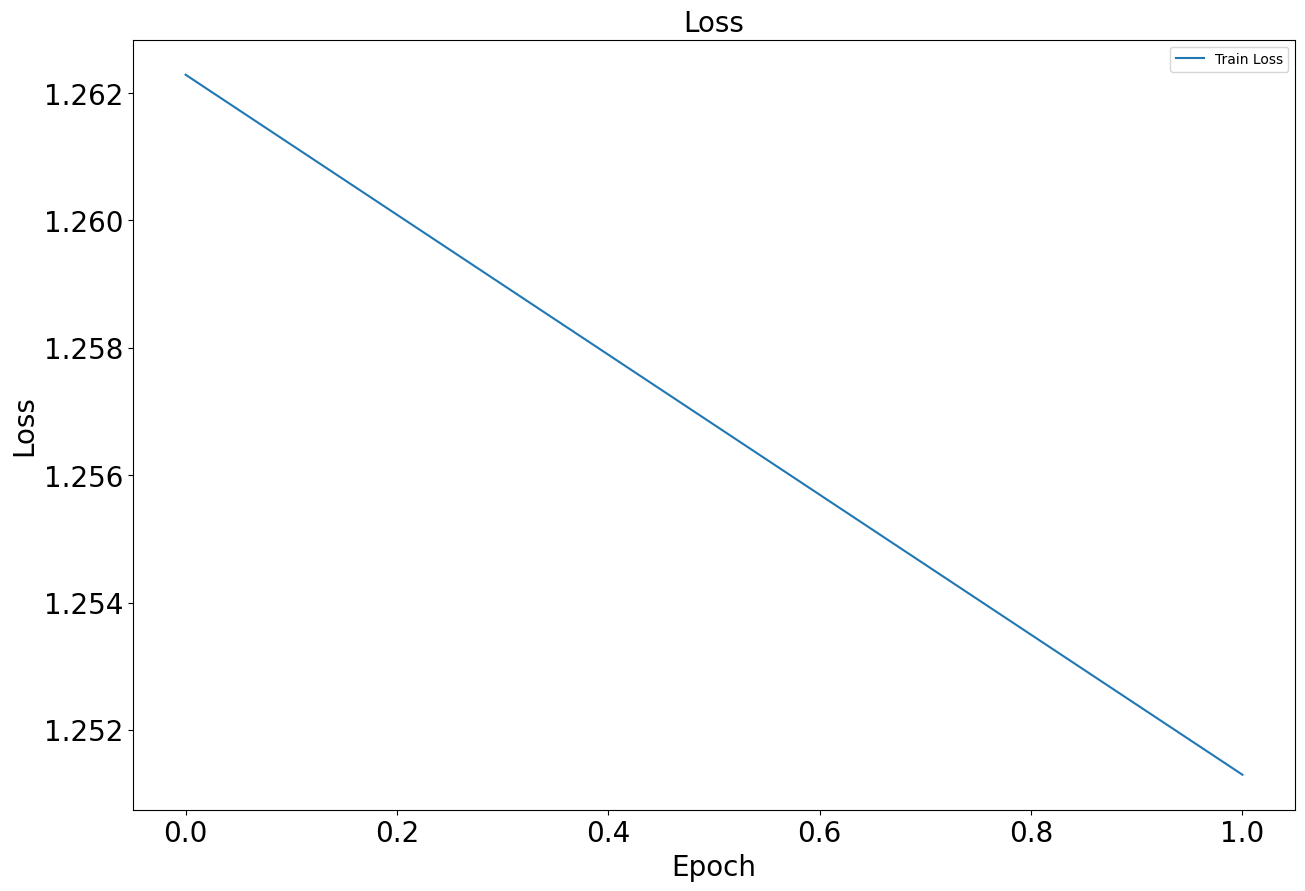

In [246]:
# Plot loss
fig = plt.figure()
n_epochs = len(train_losses)
plt.plot(list(range(n_epochs)), train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.show()

### B) Evaluation

In [188]:
@torch.no_grad()
def evaluate_model(model, loader, device="cpu", threshold=0.5):
    """
        Generated with ChatGPT.
        
        Evaluate a binary classifier (e.g. GNN) on a PyG DataLoader.
        Handles class imbalance by reporting balanced metrics.
    """
    model.eval()
    y_true, y_pred, y_prob = [], [], []

    for batch in loader:
        batch = batch.to(device)
        out = model(batch)

        # --- Binary outputs ---
        if (BINARY_CLASSIF):
            # If model returns logits → apply sigmoid
            if out.ndim > 1 and out.size(-1) == 1:
                prob = torch.sigmoid(out.view(-1)).cpu().numpy()
            else:
                prob = torch.sigmoid(out).view(-1).cpu().numpy()
    
            pred = (prob >= threshold).astype(int)
    
            # Get true labels (must be 0/1 tensor)
            y = batch.y.view(-1).cpu().numpy()
    
            y_true.extend(y)
            y_pred.extend(pred)
            y_prob.extend(prob)
        else:
            raise NotImplementedError()

    # --- Compute metrics ---
    y_true = torch.tensor(y_true)
    y_pred = torch.tensor(y_pred)
    y_prob = torch.tensor(y_prob)

    metrics = {}
    try:
        metrics["roc_auc"] = float(roc_auc_score(y_true, y_prob))
    except ValueError:
        metrics["roc_auc"] = float("nan")  # only one class present

    metrics["f1"] = f1_score(y_true, y_pred, zero_division=0)
    metrics["precision"] = precision_score(y_true, y_pred, zero_division=0)
    metrics["recall"] = recall_score(y_true, y_pred, zero_division=0)
    metrics["balanced_acc"] = balanced_accuracy_score(y_true, y_pred, adjusted=True)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics["tn"], metrics["fp"], metrics["fn"], metrics["tp"] = int(tn), int(fp), int(fn), int(tp)

    return metrics


In [189]:
# Creating test dataset
test_dataset_path = "./test_aiidkit_hetero_data.pt"
if (os.path.exists(test_dataset_path)):
    # Load dataset
    test_dataset = torch.load(test_dataset_path, weights_only=False)
    print("\n=========>Test dataset LOADED<=========\n")
else:
    # Parallelize to accelerate computation?
    #USE_PARALLELIZATION_DATASET_CREATION = True
    USE_PARALLELIZATION_DATASET_CREATION = False
    if (USE_PARALLELIZATION_DATASET_CREATION):
        raise NotImplementedError("Parallel creation of the dataset is not implemented yet (problem with Jupyter)")
    else:
        test_dataset = create_heterodata_dataset_not_parallel(
                                                                    patients_dataset=pats_dataset,
                                                                    ids_ent_attr_pairs=ids_ent_attr_pairs,
                                                                    continuous_ent_attr_pairs=continuous_ent_attr_pairs,
                                                                    categorical_ent_attr_pairs=categorical_ent_attr_pairs,
                                                                    data_split='Test',
                                                                    label_type="infection_label_binary_bacterial",
                                                                    #perc_patients_keep=1,
                                                                    perc_patients_keep=0.07,
                                                              )
    # Saving the dataset
    torch.save(test_dataset, test_dataset_path)
    print("\n=========>Test dataset SAVED<=========\n")

# Normalize dataset
normalized_test_dataset = normalized_dataset(dataset=test_dataset, statistics=train_statistics)

# Data loader creation
BS = 8
test_loader = DataLoader(normalized_test_dataset, batch_size=BS)  # batching heterogeneous graphs


=========>Test dataset LOADED<=========



  0%|          | 0/55 [00:00<?, ?it/s]

In [190]:
# Evaluate model on the TRAIN dataset
print("\n\n=========> TRAIN performance<=========\n\n")
#evaluate_model(model, train_loader, device='cpu', threshold=0.5)
evaluate_model(model, train_loader, device=DEVICE, threshold=0.5)




=========> TRAIN performance<=========




{'roc_auc': nan,
 'f1': 0.0,
 'precision': 0.0,
 'recall': 0.0,
 'balanced_acc': 0.0,
 'tn': 234,
 'fp': 0,
 'fn': 27,
 'tp': 0}

In [191]:
# Evaluate model on the TEST dataset
print("\n\n=========> TEST performance<=========\n\n")
#evaluate_model(model, test_loader, device='cpu', threshold=0.5)
evaluate_model(model, test_loader, device=DEVICE, threshold=0.5)




=========> TEST performance<=========




{'roc_auc': nan,
 'f1': 0.0,
 'precision': 0.0,
 'recall': 0.0,
 'balanced_acc': 0.0,
 'tn': 50,
 'fp': 0,
 'fn': 5,
 'tp': 0}